# Handgeschriebene Ziffern

Der beiliegenden Beschreibung der Daten habe ich entnommen, dass es sich um handgeschriebene Ziffern handelt. Die mit 16x16 Bildpunkten abgespeichert sind. Der Beschreibung kann ich weiter entnehmen:

*"The data are in two gzipped files, and each line consists of the digit
id (0-9) followed by the 256 grayscale values."*

Es handelt sich also um eine Textdatei in der in jeder Zeile der Wert der geschriebenen Ziffer sowie die 16x16 = 256 Bildpunkte stehen.

---

In [94]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

---

In [95]:
def getNumber(data, digit):
    # wähle alle Zeilen in denen die erste Spalte (Spalte mit den Ziffer) mit 'digit' übereinstimmt
    data_number = pd.DataFrame(data[data[0] == digit]) 
    # schneide die erste Spalte weg und gebe den rest zurück
    separated_data = data_number.iloc[:,1:]
    return separated_data


In [96]:
def getNumberImage(data, digit, aggregation):
    # ruft die Hilfsfunktion getNumber auf um alle Bilddaten Daten zu einer Ziffer zu holen
    image_data = getNumber(data, digit)
    # bilde aus allen Bildern zu der einen Ziffer ein aggrigiertes Bild
    if(aggregation == 'median'):
        df1 = pd.DataFrame(image_data.median())
    else:
        df1 = pd.DataFrame(image_data.mean())        
    
    # wandle das format von (1,256) -> (16,16) und gebe diesen transformierten DataFrame zurück
    return df1.values.reshape(16,16)

---

In [97]:
# mit header=None, wird die erste Zeile der Datei nicht als Header interpretiert 
#              (Man könnte den Header in einem solchen Fall als Zeile mit den Spaltenüberschriften bezeichnen)
# mit sep=" ", geben wir an, dass wir das Leerzeichen als Seperator verwenden wollen. 
#              D.h. zwei durch ein Leerzeichen separierte Werte sollen als zwei Werte eingelesen werden.
data_train = pd.read_csv("../../data/zip.train", header=None, sep=" ") 

In [98]:
cleaned_train_data = data_train.dropna(axis=1, thresh=2) # lass alle Spalten mit mehr als 2 NaN (Not a Number) vom datensatz fallen 
cleaned_train_data.shape

(7291, 257)

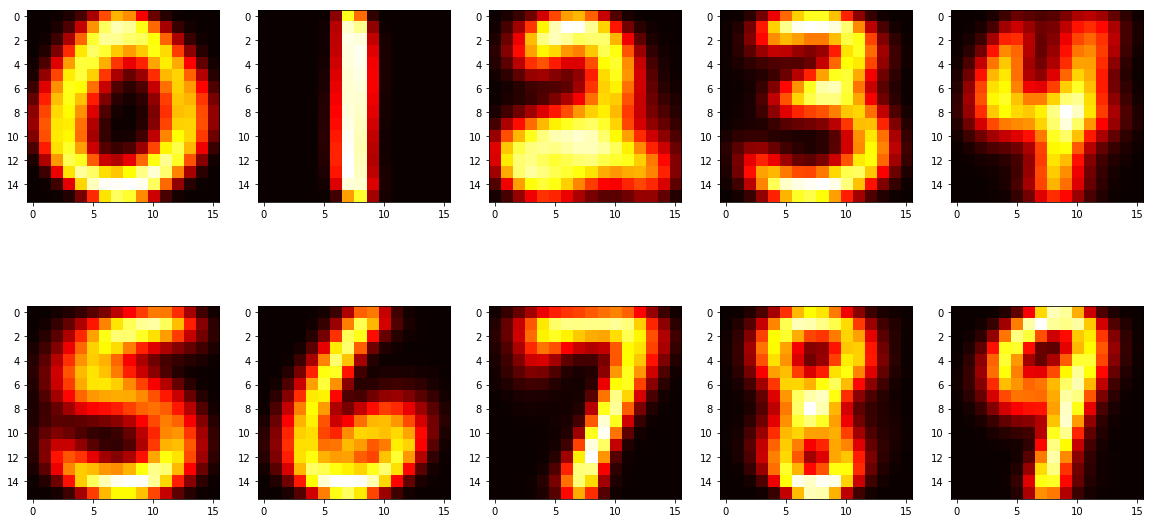

In [99]:
plt.figure(1, figsize=(20, 10))
for i in range(0,10):
    image = getNumberImage(cleaned_train_data,i,'mean')

    # Call signature: subplot(nrows, ncols, index, **kwargs)
    plt.subplot(2,5, 1 + i)
    plt.imshow(image, cmap='hot', interpolation='none')

plt.show()

---

In [100]:
data_test = pd.read_csv("../../data/zip.test", header=None, sep=" ") 

In [101]:
cleaned_test_data = data_test.dropna(axis=1, thresh=2) # lass alle Spalten mit mehr als 2 NaN (Not a Number) vom datensatz fallen 
cleaned_test_data.shape

(2007, 257)

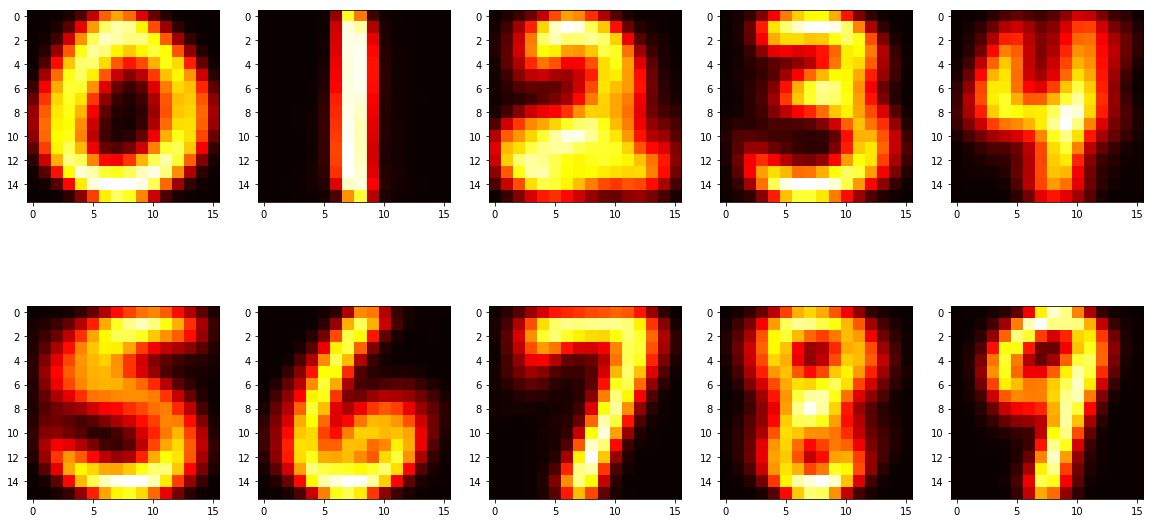

In [102]:
plt.figure(1, figsize=(20, 10))
for i in range(0,10):
    image = getNumberImage(cleaned_test_data,i,'mean')

    # Call signature: subplot(nrows, ncols, index, **kwargs)
    plt.subplot(2,5, 1 + i)
    plt.imshow(image, cmap='hot', interpolation='none')

plt.show()

---

## Split data in train und test

In [103]:
# train data
train_data = cleaned_train_data.iloc[:,1:].values
train_target = cleaned_train_data.iloc[:,0].values
print(train_data.shape)
print(train_target.shape)

(7291, 256)
(7291,)


In [104]:
# test data
test_data = cleaned_test_data.iloc[:,1:].values
test_target = cleaned_test_data.iloc[:,0].values
print(test_data.shape)
print(test_target.shape)

(2007, 256)
(2007,)


-----

In [105]:
dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0") # Uncomment this to run on GPU

In [106]:
N = train_data.shape[0] # 7291
D_in = train_data.shape[1] #256
H1 = 32
D_out = 4

x = torch.tensor(train_data, dtype=torch.float32)
y = torch.tensor(train_target, dtype=torch.long)

In [107]:
N

7291

In [108]:
"""1 layer
# Neural Network
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(D_in, D_out),
            torch.nn.ReLU(),

        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(D_out, D_in),
            torch.nn.Tanh()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
"""

'1 layer\n# Neural Network\nclass autoencoder(nn.Module):\n    def __init__(self):\n        super(autoencoder, self).__init__()\n        \n        self.encoder = torch.nn.Sequential(\n            torch.nn.Linear(D_in, D_out),\n            torch.nn.ReLU(),\n\n        )\n\n        self.decoder = torch.nn.Sequential(\n            torch.nn.Linear(D_out, D_in),\n            torch.nn.Tanh()\n        )\n        \n    def forward(self, x):\n        x = self.encoder(x)\n        x = self.decoder(x)\n        return x\n'

In [109]:
"2 layer"
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(D_in, H1),
            torch.nn.ReLU(),
            torch.nn.Linear(H1, D_out)
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(D_out, H1),
            torch.nn.ReLU(),
            torch.nn.Linear(H1, D_in),
            torch.nn.Tanh()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
        

In [110]:
model = autoencoder()

### Hyperparameter

In [111]:
learning_rate = 0.001
batch_size = 32

# Regularisierung
weight_decay=0.005

https://pytorch.org/docs/stable/optim.html

In [112]:
# SGD
# Parameters:	
# params (iterable) – iterable of parameters to optimize or dicts defining parameter groups
# lr (float) – learning rate
# momentum (float, optional) – momentum factor (default: 0)
# weight_decay (float, optional) – weight decay (L2 penalty) (default: 0)
# dampening (float, optional) – dampening for momentum (default: 0)
# nesterov (bool, optional) – enables Nesterov momentum (default: False)

# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [113]:
# ADAM
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [114]:
# LBFGS
# optimizer = torch.optim.LBFGS(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [115]:
# RMSprop
# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay) 

In [116]:
# Loss
criterion = nn.MSELoss()

## Train

In [117]:
loss_hist = []

In [118]:
# Train
epochs = range(200)
idx = 0
for t in epochs:
    for batch in range(0, int(N/batch_size)):
        # Berechne den Batch
        batch_x = x[batch * batch_size : (batch + 1) * batch_size, :]
        
        # Berechne die Vorhersage (foward step)
        outputs = model.forward(batch_x)
        
        # Berechne den Fehler (Ausgabe des Fehlers alle 100 Iterationen)
        loss = criterion(outputs, batch_x)
        
        # Berechne die Gradienten und Aktualisiere die Gewichte (backward step)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Berechne den Fehler (Ausgabe des Fehlers alle 100 Iterationen)
    if t % 20 == 0:
        loss_hist.append(loss.item())
        print(t, loss.item())

0 0.3358030915260315
20 0.28727462887763977
40 0.28482234477996826
60 0.2842320501804352
80 0.28449779748916626
100 0.28470784425735474
120 0.28479433059692383
140 0.2847859859466553
160 0.2849179804325104
180 0.28494253754615784


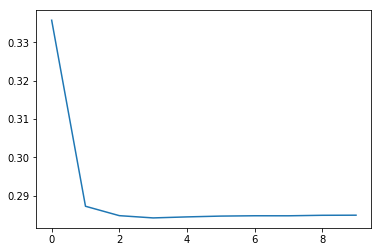

In [119]:
plt.plot(loss_hist);

In [122]:
name_list = []
weights_list = []
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name,param)
        name_list.append(name)
        weights_list.append(param.data)


encoder.0.weight Parameter containing:
tensor([[-4.2841e-06, -4.2454e-06, -4.7767e-06,  ..., -4.8961e-06,
         -4.6853e-06, -4.4956e-06],
        [-6.2746e-03, -4.9890e-03, -3.4559e-03,  ..., -7.8986e-03,
         -7.2040e-03, -6.8322e-03],
        [-1.8307e-02, -2.3106e-02, -2.6077e-02,  ..., -2.0287e-02,
         -1.8880e-02, -1.6632e-02],
        ...,
        [-6.4505e-03, -8.5759e-03, -1.1774e-02,  ..., -1.0048e-02,
         -8.1475e-03, -6.8097e-03],
        [-2.9783e-07, -2.6132e-07, -2.3984e-07,  ..., -3.5319e-07,
         -3.5200e-07, -3.3128e-07],
        [ 9.9565e-10,  8.6019e-10,  6.0495e-10,  ...,  9.9184e-10,
          1.0398e-09,  1.0419e-09]], requires_grad=True)
encoder.0.bias Parameter containing:
tensor([ 4.4941e-06,  6.8137e-03,  1.6899e-02,  6.6041e-03, -4.7094e-08,
         6.5112e-03,  1.4500e-02,  5.8395e-27,  9.1620e-08,  2.1066e-14,
        -4.0617e-07,  6.1459e-04,  1.8106e-03,  2.8842e-02,  2.3838e-02,
         8.4545e-02,  4.2320e-05, -3.4518e-12, -6.009

In [88]:
# for 1 layer: weights_firstnode = weights_list[0][0].reshape(16,16)
#weights_firstnode

In [126]:
multiplied = weights_list[2].mm(weights_list[0])

In [130]:
multiplied[0]

tensor([ 0.0311,  0.0118, -0.0079, -0.0370, -0.0680, -0.1056, -0.1145,  0.0191,
        -0.0156, -0.1151, -0.1168, -0.0930, -0.0602, -0.0330,  0.0041,  0.0321,
         0.0204, -0.0215, -0.0807, -0.1573, -0.2139, -0.2562, -0.2417, -0.0393,
         0.0045, -0.1939, -0.2541, -0.2170, -0.1723, -0.1160, -0.0443,  0.0145,
         0.0169, -0.0336, -0.1038, -0.1766, -0.2047, -0.1976, -0.1446,  0.1126,
         0.1323, -0.1033, -0.1922, -0.2197, -0.2263, -0.1547, -0.0706,  0.0031,
         0.0088, -0.0349, -0.1006, -0.1425, -0.1190, -0.0818,  0.0352,  0.2622,
         0.2046, -0.0280, -0.1034, -0.1827, -0.2586, -0.1848, -0.0728,  0.0037,
         0.0087, -0.0430, -0.0922, -0.0840, -0.0392,  0.0216,  0.1315,  0.2687,
         0.1504, -0.0562, -0.1040, -0.1678, -0.2449, -0.1799, -0.0586,  0.0157,
         0.0109, -0.0448, -0.0702, -0.0391,  0.0091,  0.0562,  0.1030,  0.1791,
         0.0736, -0.1226, -0.1478, -0.1661, -0.1870, -0.1187, -0.0362,  0.0231,
         0.0166, -0.0331, -0.0453, -0.01

In [90]:
model.named_parameters

<bound method Module.named_parameters of autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=256, out_features=4, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): Tanh()
  )
)>

In [134]:
"""
# for 1 layer:
plt.figure(1, figsize=(20, 10))

for i in range(0,D_out):
    image = weights_list[0][i].reshape(16,16)
    plt.subplot(2,5,1+i)
    plt.imshow(image, cmap='hot', interpolation='none')
    plt.colorbar(fraction=0.046,pad=0.04)
plt.tight_layout()
plt.show()

"""


"\n# for 1 layer:\nplt.figure(1, figsize=(20, 10))\n\nfor i in range(0,D_out):\n    image = weights_list[0][i].reshape(16,16)\n    plt.subplot(2,5,1+i)\n    plt.imshow(image, cmap='hot', interpolation='none')\n    plt.colorbar(fraction=0.046,pad=0.04)\nplt.tight_layout()\nplt.show()\n\n"

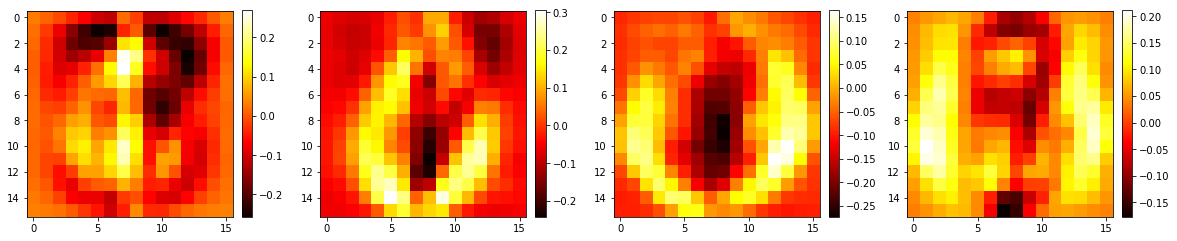

In [133]:
# for 2 layers:
plt.figure(1, figsize=(20, 10))

for i in range(0,D_out):
    image = multiplied[i].reshape(16,16)
    plt.subplot(2,5,1+i)
    plt.imshow(image, cmap='hot', interpolation='none')
    plt.colorbar(fraction=0.046,pad=0.04)
plt.tight_layout()
plt.show()

## Test

In [25]:
x_test = torch.tensor(test_data, dtype=torch.float32)

In [26]:
outputs = model.forward(x_test[0])

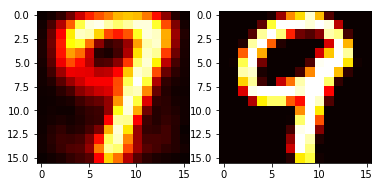

In [27]:
plt.figure(1)
plt.subplot(1,2,1)
plt.imshow(outputs.data.numpy().reshape((16,16)), cmap='hot', interpolation='none')
plt.subplot(1,2,2)
plt.imshow(test_data[0].reshape((16,16)), cmap='hot', interpolation='none')

In [28]:
image_reconstructed = model.decoder(model.encoder(x_test[0]))

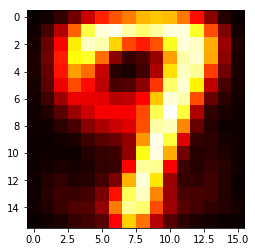

In [29]:
plt.imshow(image_reconstructed.data.numpy().reshape((16,16)), cmap='hot', interpolation='none')